In [2]:
import math
import json
import os
from pprint import pprint

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import torch

from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

from src.config.storage import ExperimentType
from src.storage import (
    get_dot_product_paraphrased_files, get_dot_product_model_generated_files,
    get_results_parameters_per_layer_folder_path, get_results_accuracy_per_layer_folder_path,
    get_results_layer_comparison_full_gradient_folder_path,
    get_results_self_similarities_over_layers_folder_path,
    get_gradient_similarity_paraphrased_random_projection_data
)
from src.dataset import get_samples
from src.model import get_model, get_num_parameters_per_layer

In [3]:
def calculate_cosine_similarity(a_dot_b, a_dot_a, b_dot_b):
    # calculates the cosine similarity based on dot products
    return a_dot_b / (math.sqrt(a_dot_a) * math.sqrt(b_dot_b))

In [4]:
def calculate_score(gradient_similarities: dict):
    correct_counter = 0
    bm25_correct_counter = 0

    size = len(gradient_similarities.keys())

    for paraphrased_id, similarities in gradient_similarities.items():
        most_similar_original_id = max(similarities, key=similarities.get)
        correct_counter += int(paraphrased_id == most_similar_original_id)

        bm25_most_similar_original_id = list(similarities.keys())[0]
        bm25_correct_counter += int(paraphrased_id == bm25_most_similar_original_id)

    return correct_counter / size, bm25_correct_counter / size

In [5]:
def get_wrong_decisions(gradient_similarities: dict):
    wrong_decisions = []

    for original_id, similarities in gradient_similarities.items():
        most_similar_paraphrased_id = max(similarities, key=similarities.get)
        if original_id != most_similar_paraphrased_id:
            wrong_decisions.append(original_id)

    return wrong_decisions

In [6]:
def get_mean_similarity_of_most_similar_samples(gradient_similarities: dict, mean_function = np.mean):
    highest_similarities = []

    for original_id, similarities in gradient_similarities.items():
        highest_similarities.append(max(similarities.values()))

    return mean_function(highest_similarities)

In [7]:
def calculate_accuracy_per_layer(cosine_similarities_new_structure: dict):
    correct_counter_per_layer = defaultdict(int)

    # amount of paraphrased_samples
    size = len(next(iter(cosine_similarities_new_structure.values())).keys())

    for layer, values in cosine_similarities_new_structure.items():
        for paraphrased_id, original_ids in values.items():
            most_similar_original_id = max(original_ids, key=original_ids.get)
            correct_counter_per_layer[layer] += int(paraphrased_id == most_similar_original_id)

        # divide by size to get percentage
        correct_counter_per_layer[layer] /= size

    return correct_counter_per_layer

In [8]:
def get_cosine_similarities(dot_product_storage_function, model_to_evaluate: str, sample_size: int | None) -> \
    tuple[
        dict[str, dict[str, dict[str, float]]],
        dict[str, dict[str, dict[str, float]]],
        dict[str, dict[str, float]],
        dict[str, dict[str, dict[str, tuple[float, float, float]]]]
    ]:
    dot_products, paraphrased_dot_products, original_dot_products = dot_product_storage_function(model_to_evaluate, sample_size)

    # restructure such that layer is at outermost level in the dictionary for easier access afterward
    cosine_similarities_new_structure = dict()
    cosine_similarities_old_structure = dict()

    cosine_similarities_old_structure_combined = dict() # all gradients combined

    layer_dot_products = dict() # stores all the necessary intermediate dot products steps to calculate the cosine similarity for each layer

    for paraphrased_id, values in dot_products.items():
        cosine_similarities_old_structure[paraphrased_id] = dict()
        cosine_similarities_old_structure_combined[paraphrased_id] = dict()

        for original_id, layers in values.items():
            cosine_similarities_old_structure[paraphrased_id][original_id] = dict()
            cosine_similarities_old_structure_combined[paraphrased_id][original_id] = 0

            for layer, value in layers.items():
                if layer not in cosine_similarities_new_structure:
                    cosine_similarities_new_structure[layer] = dict()

                if paraphrased_id not in cosine_similarities_new_structure[layer]:
                    cosine_similarities_new_structure[layer][paraphrased_id] = dict()

                if layer not in layer_dot_products:
                    layer_dot_products[layer] = dict()

                if paraphrased_id not in layer_dot_products[layer]:
                    layer_dot_products[layer][paraphrased_id] = dict()

                similarity = calculate_cosine_similarity(value, paraphrased_dot_products[paraphrased_id][layer], original_dot_products[original_id][layer])

                cosine_similarities_old_structure[paraphrased_id][original_id][layer] = similarity
                cosine_similarities_new_structure[layer][paraphrased_id][original_id] = similarity

                layer_dot_products[layer][paraphrased_id][original_id] = (
                    value,
                    paraphrased_dot_products[paraphrased_id][layer],
                    original_dot_products[original_id][layer]
                )

                cosine_similarities_old_structure_combined[paraphrased_id][original_id] += value

            cosine_similarities_old_structure_combined[paraphrased_id][original_id] = calculate_cosine_similarity(
                cosine_similarities_old_structure_combined[paraphrased_id][original_id],
                sum(paraphrased_dot_products[paraphrased_id].values()),
                sum(original_dot_products[original_id].values())
            )

    # check if restructuring has worked by comparing iteratively with gradient_similarities dictionary
    for layer, values in cosine_similarities_new_structure.items():
        for paraphrased_id, original_ids in values.items():
            for original_id, similarity in original_ids.items():
                assert similarity == cosine_similarities_old_structure[paraphrased_id][original_id][layer]

    return cosine_similarities_new_structure, cosine_similarities_old_structure, cosine_similarities_old_structure_combined, layer_dot_products

In [9]:
def calculate_similarity_between_single_layer_gradient_similarity_and_full_gradient_similarity(
        gradient_similarities_per_layer_new_structure: dict[str, dict[str, dict[str, float]]],
        gradient_similarities_full_gradient_old_structure: dict[str, dict[str, float]],
) -> dict[str, float]:
    # compare each layer with the full gradient

    # flatten full gradient similarities for comparisons
    full_flattened = [item for values in gradient_similarities_full_gradient_old_structure.values() for item in values.values()]

    layer_similarity_compared_to_full_gradients = dict()

    for layer, similarities in gradient_similarities_per_layer_new_structure.items():
        layer_cosine_similarities_flattened = []

        for paraphrased_id, original_similarities in similarities.items():
            layer_cosine_similarities_flattened.extend(original_similarities.values())

        layer_similarity_compared_to_full_gradients[layer] = cosine_similarity(X=[layer_cosine_similarities_flattened], Y=[full_flattened])[0][0]

    return layer_similarity_compared_to_full_gradients

In [10]:
def get_random_projected_similarity_to_full_gradient(
        gradient_similarity_random_projection_storage_function,
        model_to_evaluate: str,
        sample_size: int,
        gradient_similarities_full_gradient_old_structure: dict[str, dict[str, float]]
):
    full_flattened = [item for values in gradient_similarities_full_gradient_old_structure.values() for item in values.values()]

    random_projection_similarities_to_full_gradient = dict()

    for projection_dim, down_projected_values in get_gradient_similarity_paraphrased_random_projection_data(model_to_evaluate, sample_size).items():
        projected_flattened = [item for values in down_projected_values.values() for item in values.values()]

        down_projected_similarity_compared_to_full_gradient = cosine_similarity(X=[projected_flattened], Y=[full_flattened])[0][0]

        random_projection_similarities_to_full_gradient[projection_dim] = down_projected_similarity_compared_to_full_gradient

    return random_projection_similarities_to_full_gradient

In [11]:
def greedy_forward_layer_selection(
        layer_dot_products: dict[str, dict[str, dict[str, tuple[float, float, float]]]],
        gradient_similarities_full_gradient_old_structure: dict[str, dict[str, float]],
) -> list[tuple[str, float]]:
    # flatten full gradient similarities for comparisons
    full_flattened = [item for values in gradient_similarities_full_gradient_old_structure.values() for item in values.values()]

    best_layers = []

    for i in range(len(layer_dot_products.keys())):
        most_similar_layer_with_properties = ("", float("-inf"), dict()) # stores the most similar layer compared to the full gradient with all properties that are later needed

        best_layer_names = list(map(lambda row: row[0], best_layers))

        for layer, paraphrased_items in filter(lambda x: x[0] not in best_layer_names, layer_dot_products.items()): # filter out layers stored in best_layers
            layer_cosine_similarities_flattened = []
            layer_intermediate_dot_products = dict()

            for paraphrased_id, original_items in paraphrased_items.items():
                layer_intermediate_dot_products[paraphrased_id] = dict()

                for original_id, (dot_product, paraphrased_dot_product, original_dot_product) in original_items.items():
                    layer_intermediate_dot_products[paraphrased_id][original_id] = (dot_product, paraphrased_dot_product, original_dot_product)

                    sum_dot_products = 0
                    sum_paraphrased_dot_products = 0
                    sum_original_dot_products = 0

                    # sum dot products of "best layers" to add them to the current layer under investigation
                    for _, _, intermediate_dot_products in best_layers:
                        sum_dot_products += intermediate_dot_products[paraphrased_id][original_id][0]
                        sum_paraphrased_dot_products += intermediate_dot_products[paraphrased_id][original_id][1]
                        sum_original_dot_products += intermediate_dot_products[paraphrased_id][original_id][2]

                    layer_cosine_similarities_flattened.append(calculate_cosine_similarity(
                        dot_product + sum_dot_products,
                        paraphrased_dot_product + sum_paraphrased_dot_products,
                        original_dot_product + sum_original_dot_products,
                    ))

            layer_similarity_compared_to_full_gradient = cosine_similarity(X=[layer_cosine_similarities_flattened], Y=[full_flattened])[0][0]

            if layer_similarity_compared_to_full_gradient > most_similar_layer_with_properties[1]:
                most_similar_layer_with_properties = (layer, layer_similarity_compared_to_full_gradient, layer_intermediate_dot_products)

        best_layers.append(most_similar_layer_with_properties)

    return list(map(lambda row: (row[0], row[1]), best_layers))


In [12]:
def find_top_k_examples_where_similarity_diverges_between_single_layer_gradient_and_full_gradient(
        layer_under_investigation: str,
        gradient_similarities_per_layer: dict[str, dict[str, dict[str, float]]],
        gradient_similarities_full_gradient: dict[str, dict[str, float]],
        k=3
) -> list[str]:
    layer_gradient_similarities = gradient_similarities_per_layer[layer_under_investigation]

    similarities = []

    for paraphrased_id, gradient_cosine_similarities in layer_gradient_similarities.items():
        sample_similarities = np.array(list(gradient_cosine_similarities.values()))
        similarities_full_gradient = np.array(list(gradient_similarities_full_gradient[paraphrased_id].values()))

        similarity = sample_similarities.dot(similarities_full_gradient) # use dot product to measure similarity since all the values are already normalized, hence magnitude doesn't play a role anymore

        similarities.append(similarity)

    most_divergent_example_indices = np.argsort(np.array(similarities))[:k]

    return list(np.array(list(layer_gradient_similarities.keys()))[most_divergent_example_indices])

In [13]:
def horizontal_bar_plot(y, x, title, storage_folder_path, scale=None):
    plt.figure(figsize=(8, 25))
    sns.barplot(y = y, x = x, orient="h")
    plt.title(title)

    if scale is not None:
        plt.xscale(scale)

    plt.margins(y=0.01)

    plt.savefig(f"{storage_folder_path}/horizontal_bar_plot.png", bbox_inches="tight")
    plt.plot()

In [14]:
def plot_gradient_similarities_over_layers(
        examples: list[str],
        gradient_similarities_per_layer_old_structure: dict[str, dict[str, dict[str, float]]],
        title: str,
        storage_folder_path: str,
):
    for paraphrased_example_under_investigation in examples:
        gradient_similarities_over_layers = pd.DataFrame(
            data=list(gradient_similarities_per_layer_old_structure["lima_0"]["lima_0"].keys()),
            columns=["layer"]
        )

        for original_example_to_compare in gradient_similarities_per_layer_old_structure[paraphrased_example_under_investigation]:
            gradient_similarities_over_layers[f"{paraphrased_example_under_investigation} <=> {original_example_to_compare}"] = list(gradient_similarities_per_layer_old_structure[paraphrased_example_under_investigation][original_example_to_compare].values())

        gradient_similarities_over_layers = gradient_similarities_over_layers.set_index("layer")

        plt.figure(figsize=(18, 8))
        sns.lineplot(data=gradient_similarities_over_layers)
        plt.ylabel("gradient similarity")
        plt.title(title)
        plt.xticks(rotation=90)

        plt.margins(y=0.01)

        #plt.savefig(f"{storage_folder_path}/line_plot.png", bbox_inches="tight")

        plt.plot()

        #self_similarities_over_layers.to_csv(os.path.join(storage_folder_path, "self_similarities_over_layers.csv"))

In [15]:
model_to_evaluate = "amd/AMD-OLMo-1B-SFT"
#model_to_evaluate = "allenai/OLMo-7B-SFT-hf"
sample_size = 100
#sample_size = None

#model_to_evaluate = "openai-community/gpt2"
#sample_size = 2

In [16]:
model = get_model(model_to_evaluate, device=torch.device('cpu')) # load model on cpu since no more computations are needed

Device: cpu
Model parameters: 1176764416
OlmoForCausalLM(
  (model): OlmoModel(
    (embed_tokens): Embedding(50304, 2048, padding_idx=1)
    (layers): ModuleList(
      (0-15): 16 x OlmoDecoderLayer(
        (self_attn): OlmoAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): OlmoMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): OlmoLayerNorm()
        (post_attention_layernorm): OlmoLayerNorm()
      )
    )
    (norm): OlmoLayerNorm()
    (rotary_emb)

In [17]:
num_parameters_per_layer = get_num_parameters_per_layer(model)

assert sum(num_parameters_per_layer.values()) == model.num_parameters()

pprint(num_parameters_per_layer, indent=4, sort_dicts=False)

{   'model.embed_tokens.weight': 103022592,
    'model.layers.0.self_attn.q_proj.weight': 4194304,
    'model.layers.0.self_attn.k_proj.weight': 4194304,
    'model.layers.0.self_attn.v_proj.weight': 4194304,
    'model.layers.0.self_attn.o_proj.weight': 4194304,
    'model.layers.0.mlp.gate_proj.weight': 16777216,
    'model.layers.0.mlp.up_proj.weight': 16777216,
    'model.layers.0.mlp.down_proj.weight': 16777216,
    'model.layers.1.self_attn.q_proj.weight': 4194304,
    'model.layers.1.self_attn.k_proj.weight': 4194304,
    'model.layers.1.self_attn.v_proj.weight': 4194304,
    'model.layers.1.self_attn.o_proj.weight': 4194304,
    'model.layers.1.mlp.gate_proj.weight': 16777216,
    'model.layers.1.mlp.up_proj.weight': 16777216,
    'model.layers.1.mlp.down_proj.weight': 16777216,
    'model.layers.2.self_attn.q_proj.weight': 4194304,
    'model.layers.2.self_attn.k_proj.weight': 4194304,
    'model.layers.2.self_attn.v_proj.weight': 4194304,
    'model.layers.2.self_attn.o_proj.

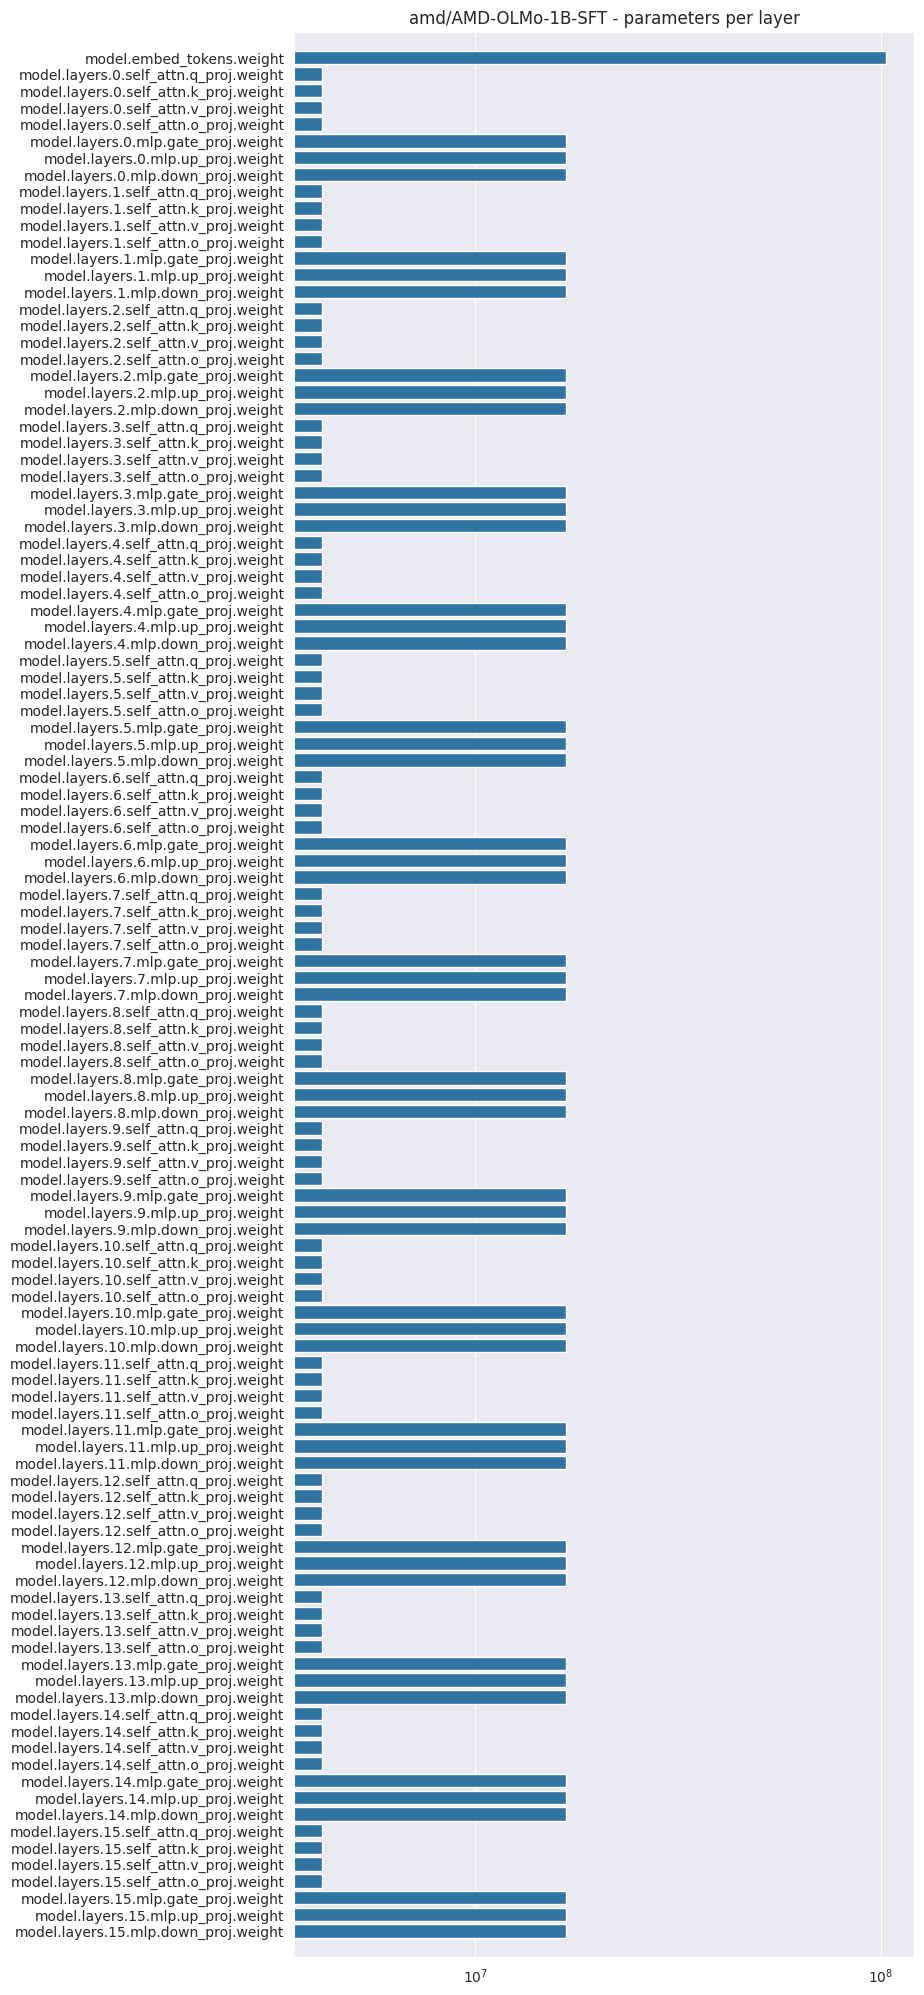

In [18]:
horizontal_bar_plot(
    y=list(num_parameters_per_layer.keys()),
    x=list(num_parameters_per_layer.values()),
    title=f"{model_to_evaluate} - parameters per layer",
    storage_folder_path=f"{get_results_parameters_per_layer_folder_path(model_to_evaluate)}",
    scale='log',
)

with open(f"{get_results_parameters_per_layer_folder_path(model_to_evaluate)}/values.json", "w") as f:
    json.dump(num_parameters_per_layer, f, indent=4)

In [18]:
cosine_similarities_new_structure_paraphrased, cosine_similarities_old_structure_paraphrased, cosine_similarities_old_structure_combined_paraphrased, layer_dot_products_paraphrased = get_cosine_similarities(get_dot_product_paraphrased_files, model_to_evaluate, sample_size)

# 1. BM25 Selected Paraphrased

In [19]:
model_score, bm25_score = calculate_score(cosine_similarities_old_structure_combined_paraphrased)
wrong_decisions = get_wrong_decisions(cosine_similarities_old_structure_combined_paraphrased)
mean_similarity = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined_paraphrased)
mean_similarity_score_median = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined_paraphrased, np.median)

print(f"Model score: {model_score}")
print(f"BM25 score: {bm25_score}")
print(f"Mean similarity (average): {mean_similarity}")
print(f"Mean similarity (median): {mean_similarity_score_median}")

Model score: 1.0
BM25 score: 0.99
Mean similarity (average): 0.5226305867108227
Mean similarity (median): 0.5039189508741513


## 1.1 Layer Analysis

In [20]:
accuracy_per_layer = calculate_accuracy_per_layer(cosine_similarities_new_structure_paraphrased)

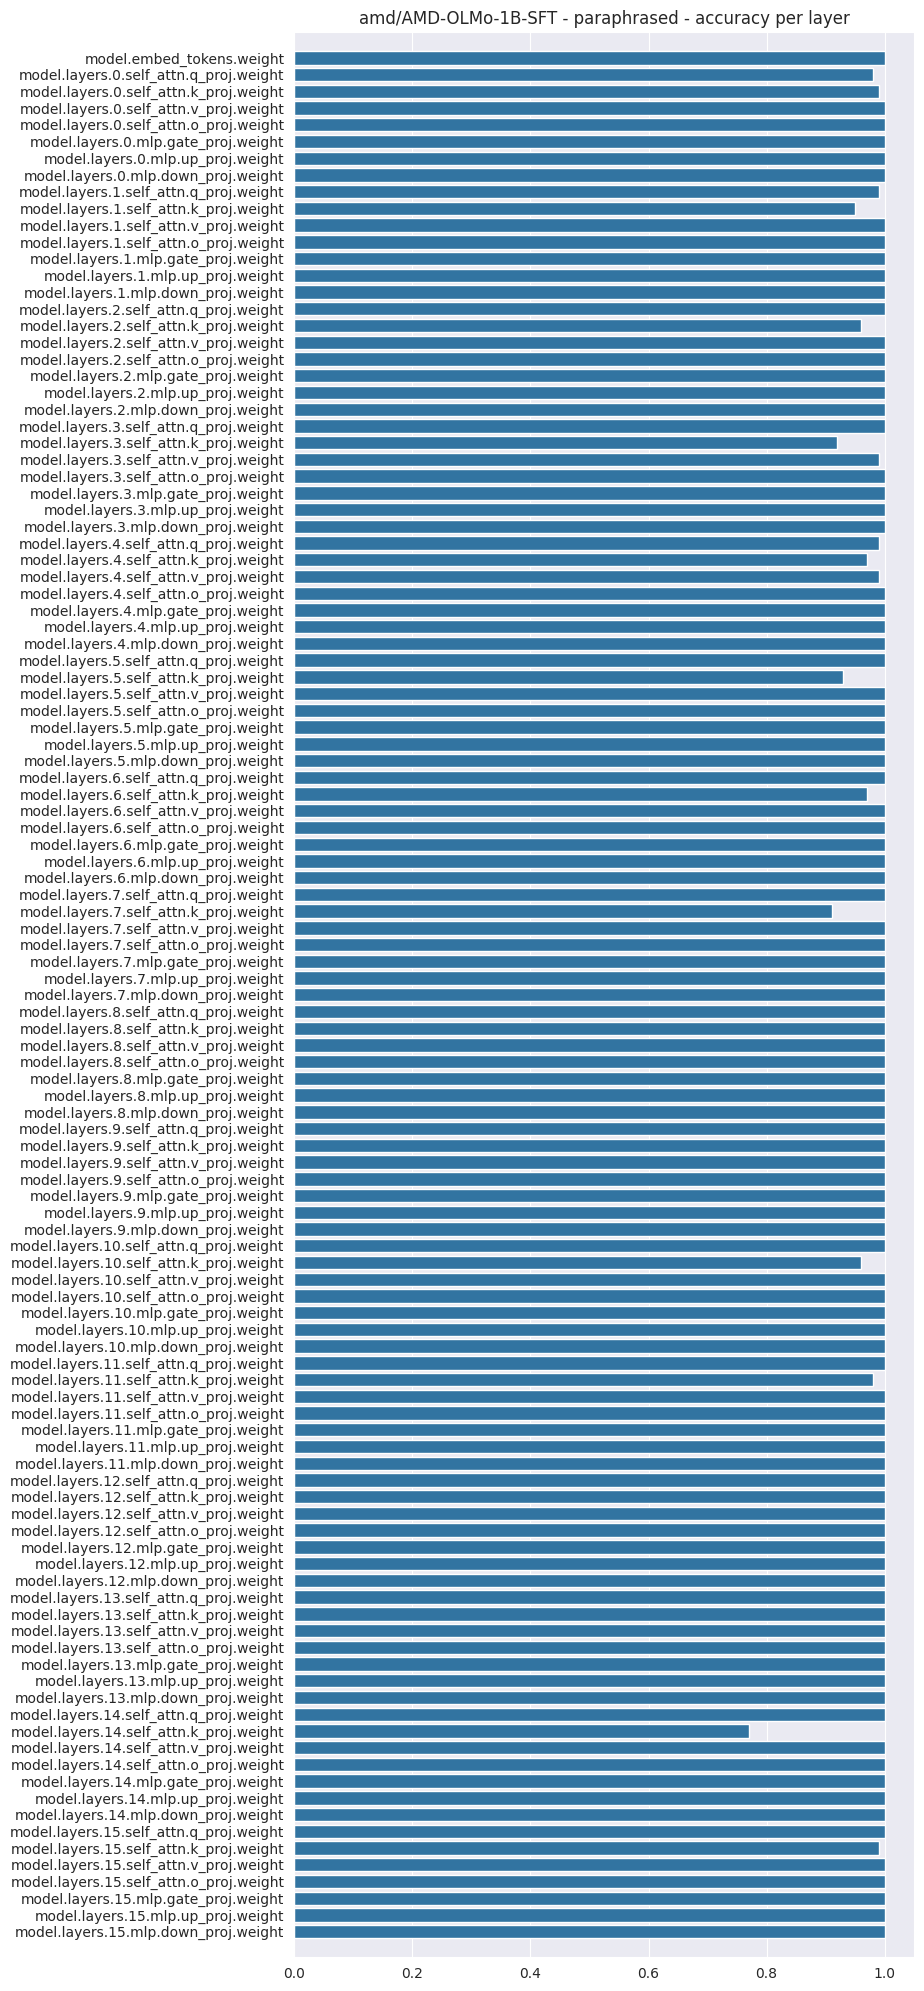

In [21]:
horizontal_bar_plot(
    y=list(accuracy_per_layer.keys()),
    x=list(accuracy_per_layer.values()),
    title=f"{model_to_evaluate} - paraphrased - accuracy per layer",
    storage_folder_path=get_results_accuracy_per_layer_folder_path(model_to_evaluate, sample_size, ExperimentType.PARAPHRASED),
)

with open(f"{get_results_accuracy_per_layer_folder_path(model_to_evaluate, sample_size, ExperimentType.PARAPHRASED)}/values.json", "w") as f:
    json.dump(accuracy_per_layer, f, indent=4)

### 1.1.1 Example Similarities over Layers

In [22]:
layer_with_best_score_paraphrased = max(accuracy_per_layer, key=accuracy_per_layer.get)
layer_with_best_score_paraphrased

'model.embed_tokens.weight'

In [23]:
examples_where_similarity_diverges_the_most_between_single_layer_gradient_and_full_gradient_paraphrased = find_top_k_examples_where_similarity_diverges_between_single_layer_gradient_and_full_gradient(layer_with_best_score_paraphrased, cosine_similarities_new_structure_paraphrased, cosine_similarities_old_structure_combined_paraphrased)

In [24]:
examples_where_similarity_diverges_the_most_between_single_layer_gradient_and_full_gradient_paraphrased

['lima_32', 'lima_37', 'lima_77']

In [25]:
for sample in get_samples(examples_where_similarity_diverges_the_most_between_single_layer_gradient_and_full_gradient_paraphrased):
    original_user_message = sample["messages"][0]["content"].replace("\n", "\n\t\t")
    original_assistant_message = sample["messages"][1]["content"].replace("\n", "\n\t\t")

    paraphrased_user_message = sample['paraphrased_messages'][0]['content'].replace("\n", "\n\t\t")
    paraphrased_assistant_message = sample['paraphrased_messages'][1]['content'].replace("\n", "\n\t\t")


    print(f"============{sample['id']}============")
    print("original:")
    print("\tuser message:")
    print(f"\t\t{original_user_message}")
    print()
    print("\tassistant message:")
    print(f"\t\t{original_assistant_message}")

    print("-----")

    print("paraphrased:")
    print("\tuser message:")
    print(f"\t\t{paraphrased_user_message}")
    print()
    print("\tassistant message:")
    print(f"\t\t{paraphrased_assistant_message}")

============lima_32============
original:
	user message:
		I've noticed that people on YouTube and even on TV would sometimes say things like "I used to take lots of coke a few years ago" or "I used to smoke weed daily until this and that" or "Yea, I smoke weed every once in a while," or "I used to pirate games a lot when I was a bit younger" or "I used pirated Windows and Photoshop until I got a job," etc., etc..
		Basically they are confessing to a crime, on public record, couldn't anyone come after them? They've already confessed - technically all that would have to be done is a trial.
		How do people publicly admit to criminal activity and not typically get arrested?

	assistant message:
		Unless the Youtube Video shows them committing a crime, then no, they couldn't be arrested and tried for a crime. Them saying it, not under oath, is just hearsay that has no evidentiary value unless there is already other evidence they have committed a crime. In that case, its an admission.  But 

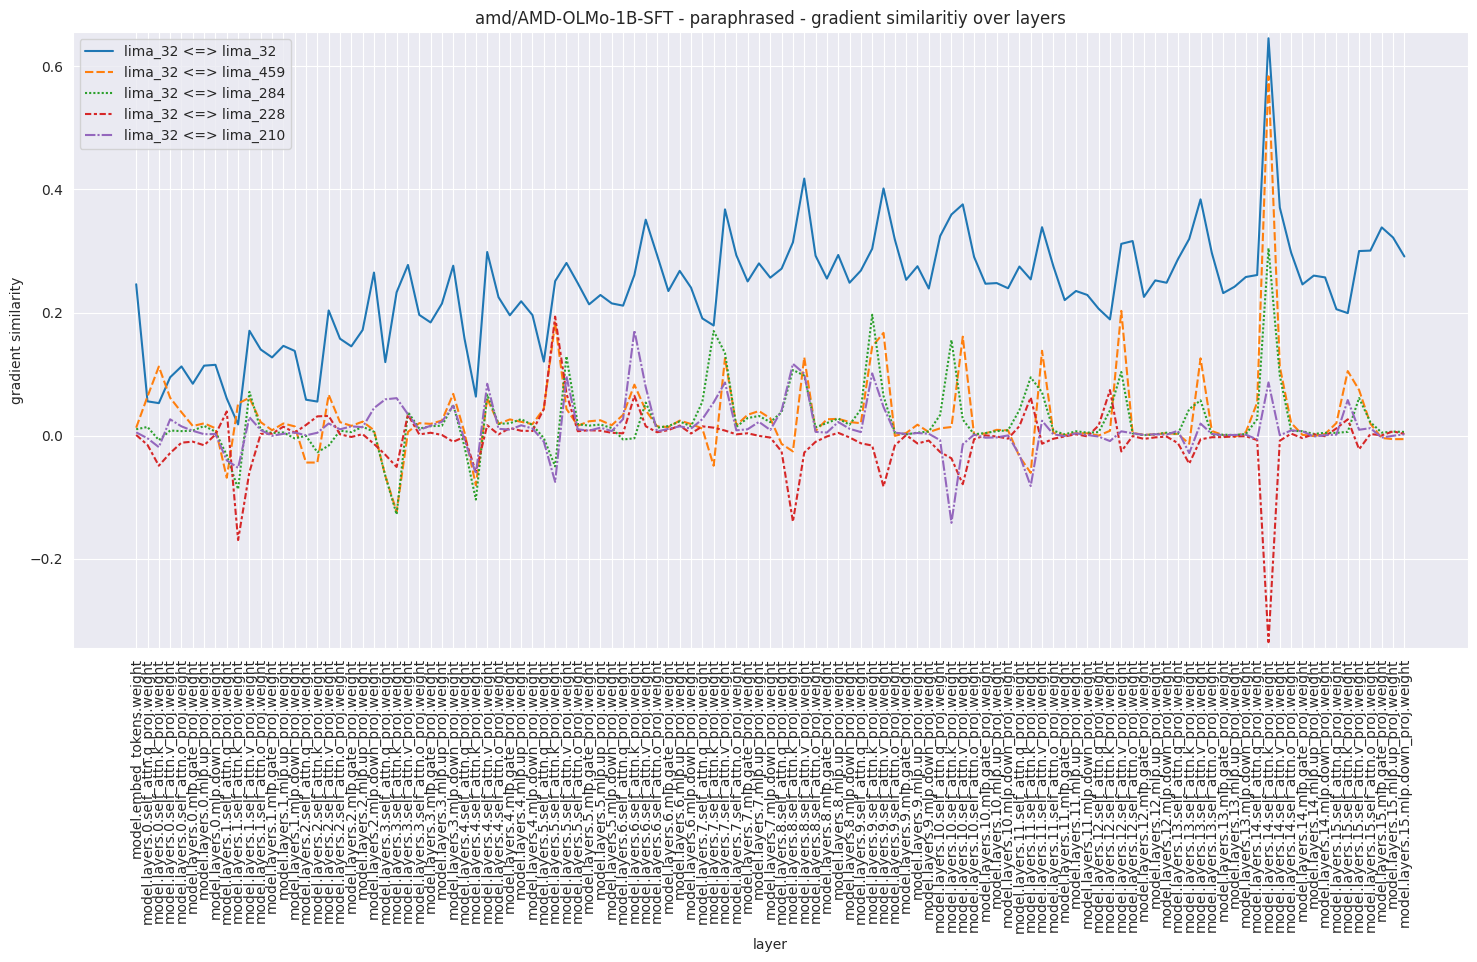

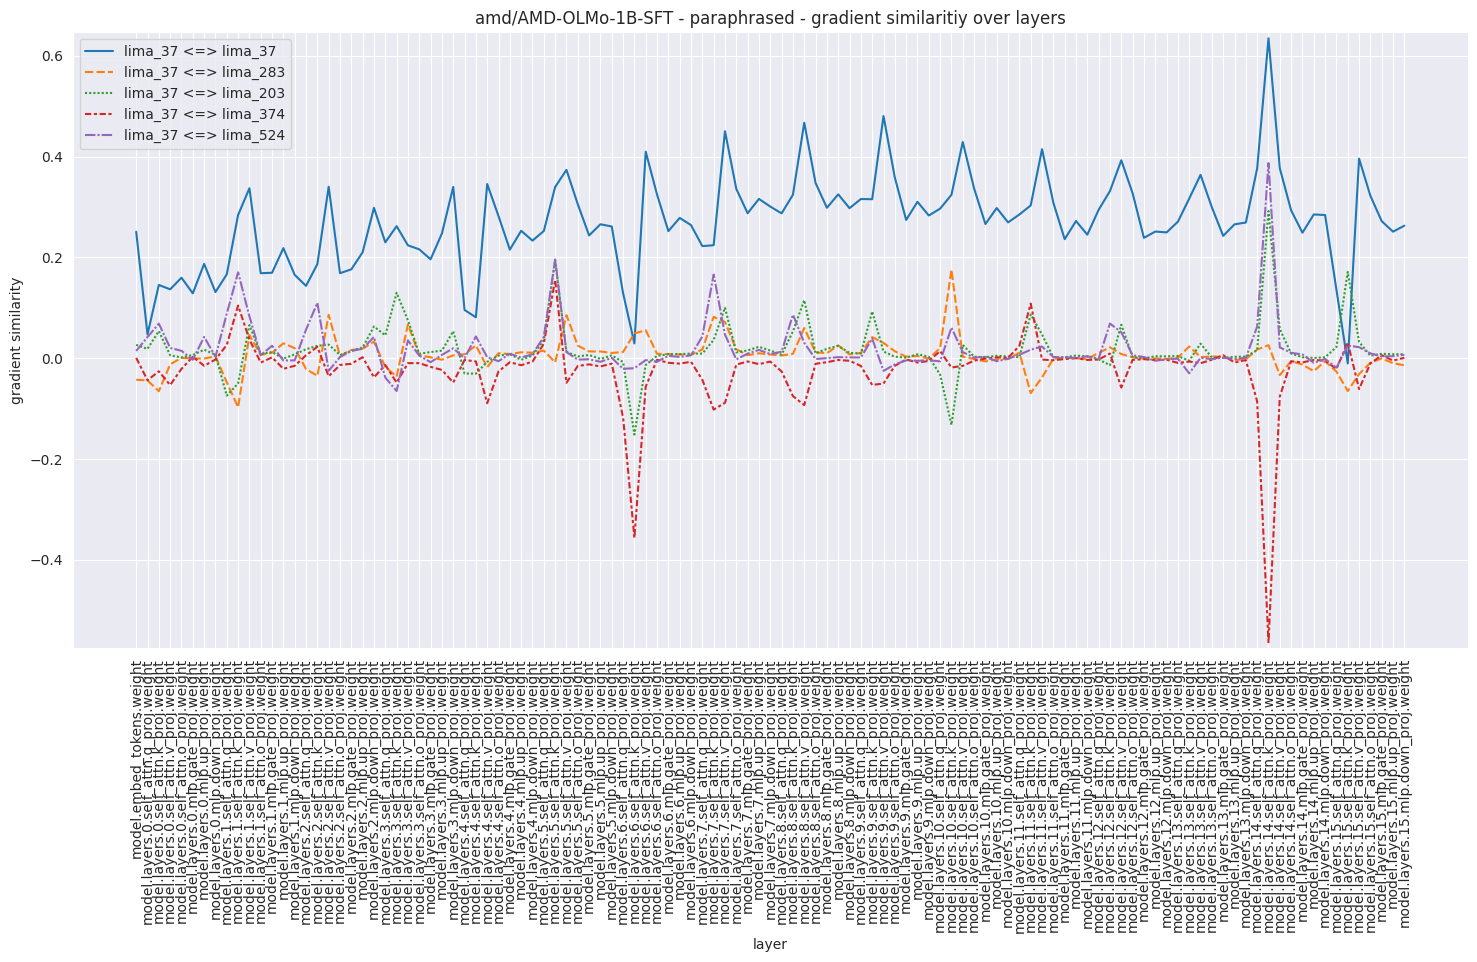

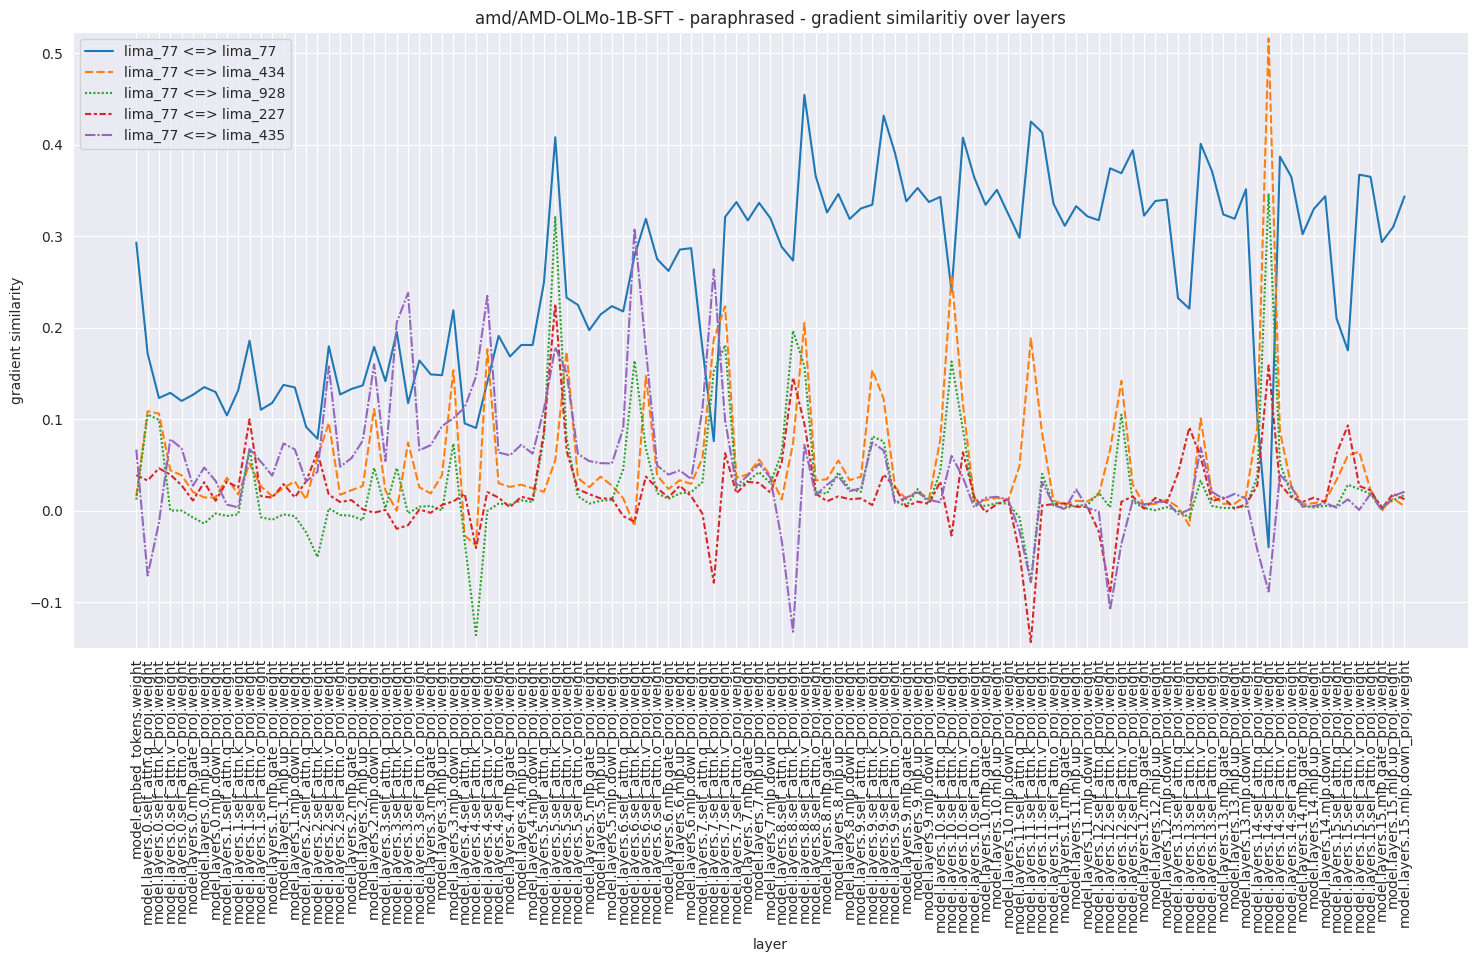

In [26]:
plot_gradient_similarities_over_layers(
    examples=examples_where_similarity_diverges_the_most_between_single_layer_gradient_and_full_gradient_paraphrased,
    gradient_similarities_per_layer_old_structure=cosine_similarities_old_structure_paraphrased,
    title=f"{model_to_evaluate} - paraphrased - gradient similaritiy over layers",
    storage_folder_path=get_results_self_similarities_over_layers_folder_path(model_to_evaluate, sample_size, ExperimentType.PARAPHRASED),
)

## 1.2 Comparison between Layer-Gradient-Similarities and Full-Gradient-Similarities

In [27]:
layer_similarity_compared_to_full_gradients_paraphrased = calculate_similarity_between_single_layer_gradient_similarity_and_full_gradient_similarity(cosine_similarities_new_structure_paraphrased, cosine_similarities_old_structure_combined_paraphrased)

In [28]:
max(layer_similarity_compared_to_full_gradients_paraphrased, key=layer_similarity_compared_to_full_gradients_paraphrased.get)

'model.layers.7.mlp.up_proj.weight'

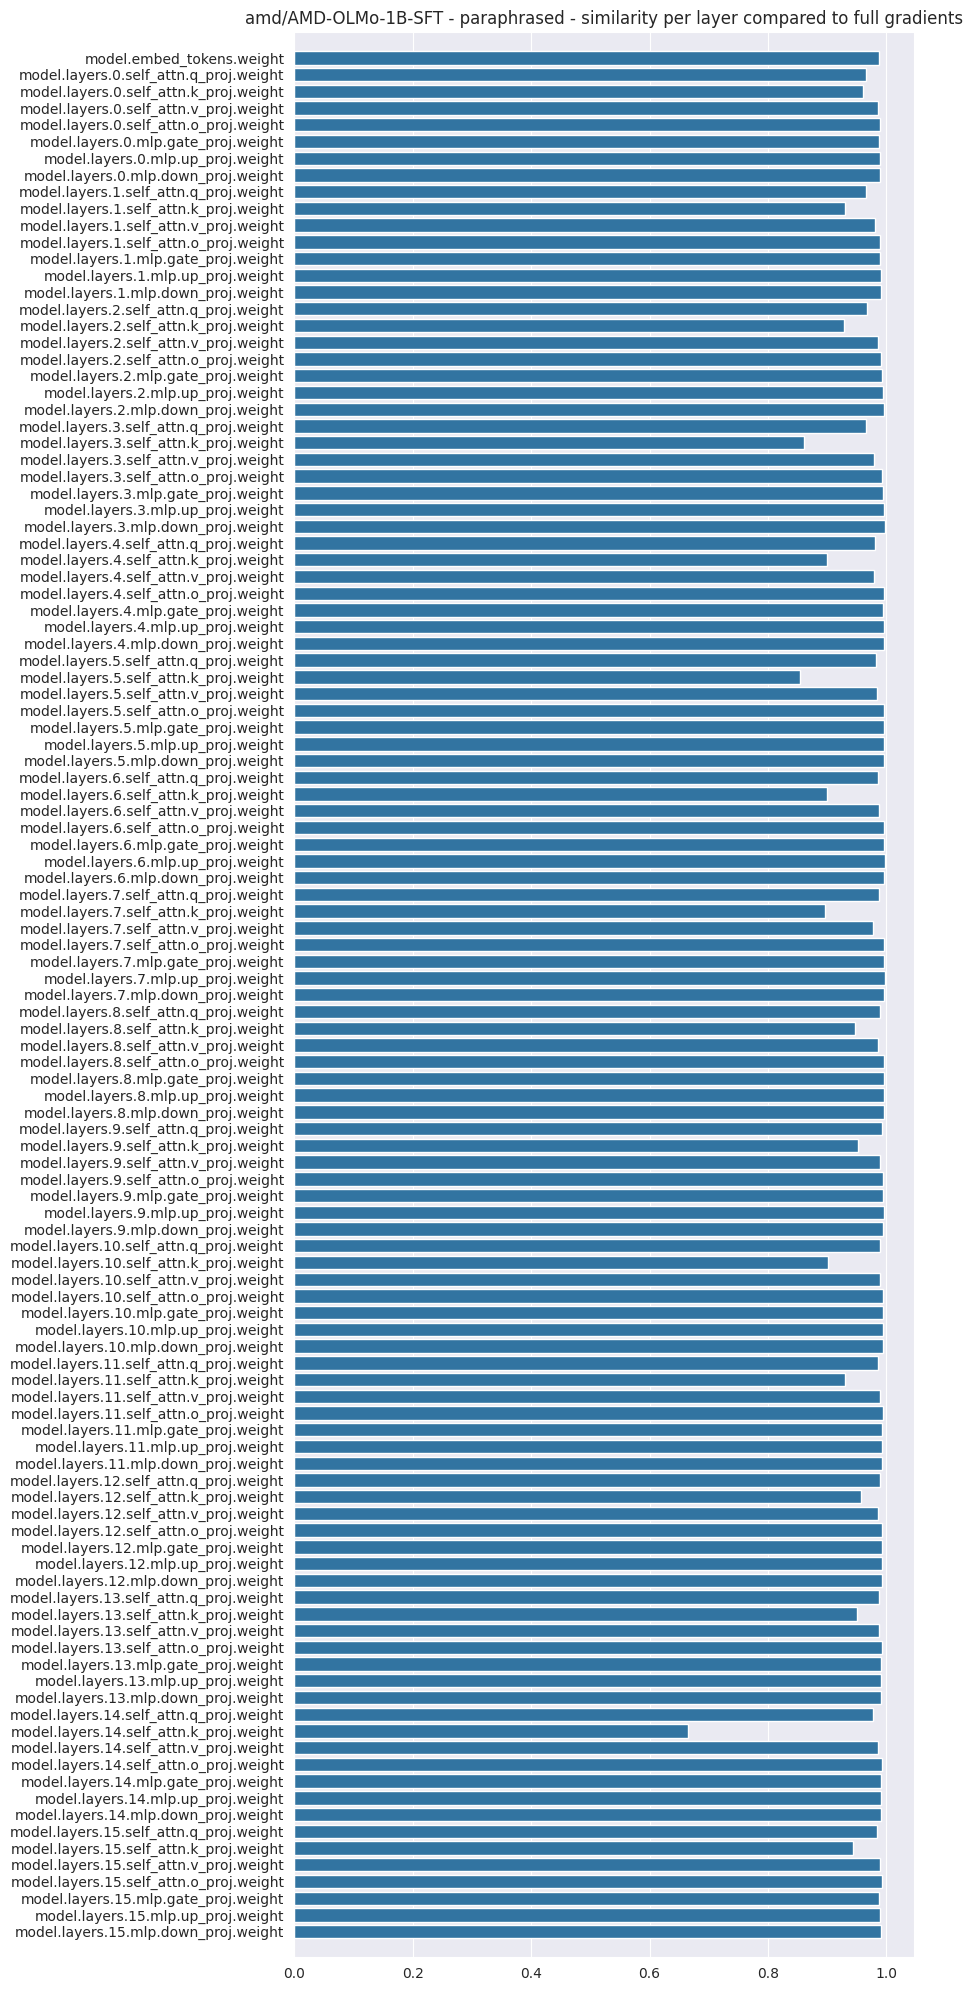

In [29]:
horizontal_bar_plot(
    y=list(layer_similarity_compared_to_full_gradients_paraphrased.keys()),
    x=list(layer_similarity_compared_to_full_gradients_paraphrased.values()),
    title=f"{model_to_evaluate} - paraphrased - similarity per layer compared to full gradients",
    storage_folder_path=get_results_layer_comparison_full_gradient_folder_path(model_to_evaluate, sample_size, ExperimentType.PARAPHRASED),
)

with open(f"{get_results_layer_comparison_full_gradient_folder_path(model_to_evaluate, sample_size, ExperimentType.PARAPHRASED)}/values.json", "w") as f:
    json.dump(layer_similarity_compared_to_full_gradients_paraphrased, f, indent=4)

### 1.2.1 Greedy Layer Selection based on Full-Gradient-Comparison

In [30]:
greedily_selected_layers_paraphrased = greedy_forward_layer_selection(layer_dot_products_paraphrased, cosine_similarities_old_structure_combined_paraphrased)

In [31]:
# accumulate layer parameters for visualization

parameter_percentage_accumulated_and_similarity_paraphrased = []
accumulated_parameters = 0

for layer, similarity_compared_to_full_gradient in greedily_selected_layers_paraphrased:
    accumulated_parameters += num_parameters_per_layer[layer]

    parameter_percentage_accumulated_and_similarity_paraphrased.append((accumulated_parameters / model.num_parameters() * 100, similarity_compared_to_full_gradient))

In [32]:
pd.DataFrame(data=parameter_percentage_accumulated_and_similarity_paraphrased, columns=["percentage", 'similarity'])

percentage  similarity
0      1.425707    0.997098
1      2.851415    0.998696
2      4.277122    0.999123
3      5.702829    0.999331
4      6.059256    0.999345
..          ...         ...
108   97.505012    0.999998
109   97.861439    0.999999
110   99.287146    1.000000
111   99.643573    1.000000
112  100.000000    1.000000

[113 rows x 2 columns]

In [33]:
down_projected_gradients_paraphrased_compared_to_full_gradient = get_random_projected_similarity_to_full_gradient(
    get_gradient_similarity_paraphrased_random_projection_data,
    model_to_evaluate,
    sample_size,
    cosine_similarities_old_structure_combined_paraphrased
)

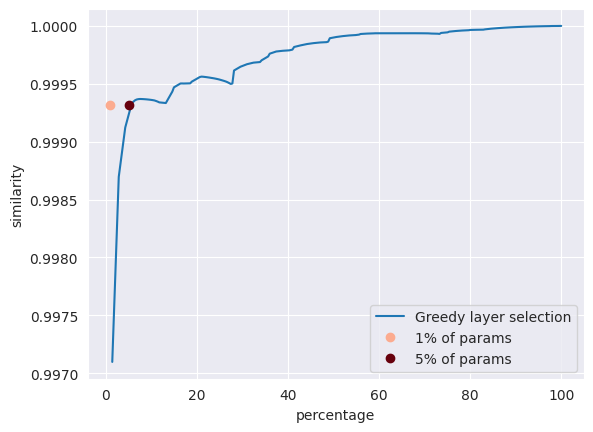

In [34]:
sns.lineplot(data=pd.DataFrame(data=parameter_percentage_accumulated_and_similarity_paraphrased, columns=["percentage", 'similarity']), x="percentage", y="similarity", label="Greedy layer selection")

colors = plt.get_cmap("Reds")(np.linspace(0.3, 1, len(down_projected_gradients_paraphrased_compared_to_full_gradient)))

for (i, (projection_dim, similarity)) in enumerate(down_projected_gradients_paraphrased_compared_to_full_gradient.items()):
    percentage_of_full_parameters = int(projection_dim) / model.num_parameters() * 100
    plt.plot(
        percentage_of_full_parameters,
        similarity,
        "o",
        color=colors[i],
        label=f"{round(percentage_of_full_parameters)}% of params"
    )

plt.title(f"")
plt.legend()
plt.show()

In [35]:
print(down_projected_gradients_paraphrased_compared_to_full_gradient)

{'11767808': 0.9993181325263832, '58838016': 0.9993153961025699}


In [37]:
parameter_percentage_accumulated_and_similarity_paraphrased

[(1.4257072844731566, 0.9970975238411248),
 (2.8514145689463133, 0.998696401606843),
 (4.2771218534194695, 0.9991225719708908),
 (5.702829137892627, 0.9993313363169447)]

# 2. BM25 Selected Model Generated

In [31]:
cosine_similarities_new_structure_model_generated, cosine_similarities_old_structure_model_generated, cosine_similarities_old_structure_combined_model_generated, layer_dot_products_model_generated = get_cosine_similarities(get_dot_product_model_generated_files, model_to_evaluate, sample_size)

In [32]:
model_score_model_generated, bm25_score_model_generated = calculate_score(cosine_similarities_old_structure_combined_model_generated)
wrong_decisions_model_generated = get_wrong_decisions(cosine_similarities_old_structure_combined_model_generated)
mean_similarity_model_generated = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined_model_generated)
mean_similarity_score_median_model_generated = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined_model_generated, np.median)

print(f"Model score: {model_score_model_generated}")
print(f"BM25 score: {bm25_score_model_generated}")
print(f"Mean similarity (average): {mean_similarity_model_generated}")
print(f"Mean similarity (median): {mean_similarity_score_median_model_generated}")

Model score: 0.2
BM25 score: 0.99
Mean similarity (average): 0.019307835217063835
Mean similarity (median): 0.01223615761901382


## 2.1 Layer Analysis

In [33]:
accuracy_per_layer_model_generated = calculate_accuracy_per_layer(cosine_similarities_new_structure_model_generated)

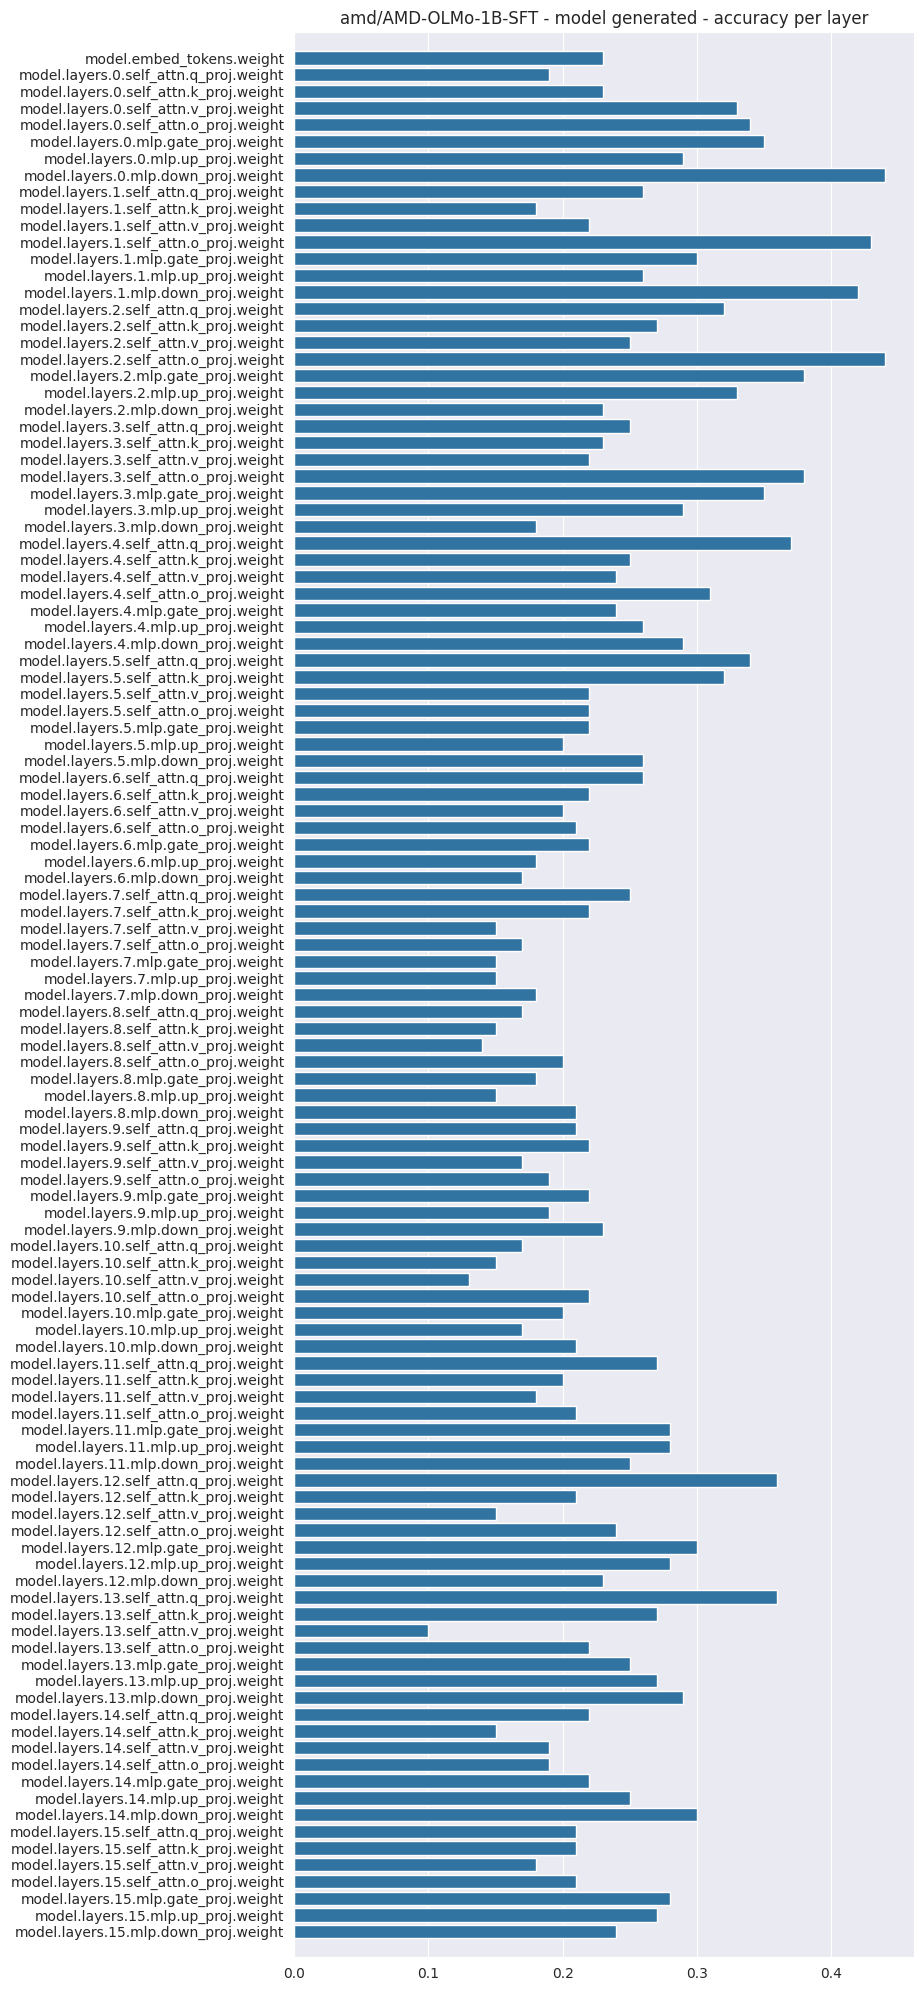

In [34]:
horizontal_bar_plot(
    y=list(accuracy_per_layer_model_generated.keys()),
    x=list(accuracy_per_layer_model_generated.values()),
    title=f"{model_to_evaluate} - model generated - accuracy per layer",
    storage_folder_path=get_results_accuracy_per_layer_folder_path(model_to_evaluate, sample_size, ExperimentType.MODEL_GENERATED),
)

with open(f"{get_results_accuracy_per_layer_folder_path(model_to_evaluate, sample_size, ExperimentType.MODEL_GENERATED)}/values.json", "w") as f:
    json.dump(accuracy_per_layer_model_generated, f, indent=4)

### 2.1.1 Example Similarities over Layers

In [35]:
layer_with_best_score_model_generated = max(accuracy_per_layer_model_generated, key=accuracy_per_layer_model_generated.get)
layer_with_best_score_model_generated

'model.layers.0.mlp.down_proj.weight'

In [36]:
examples_where_similarity_diverges_the_most_between_single_layer_gradient_and_full_gradient_model_generated = find_top_k_examples_where_similarity_diverges_between_single_layer_gradient_and_full_gradient(
    layer_with_best_score_model_generated,
    cosine_similarities_new_structure_model_generated,
    cosine_similarities_old_structure_combined_model_generated
)

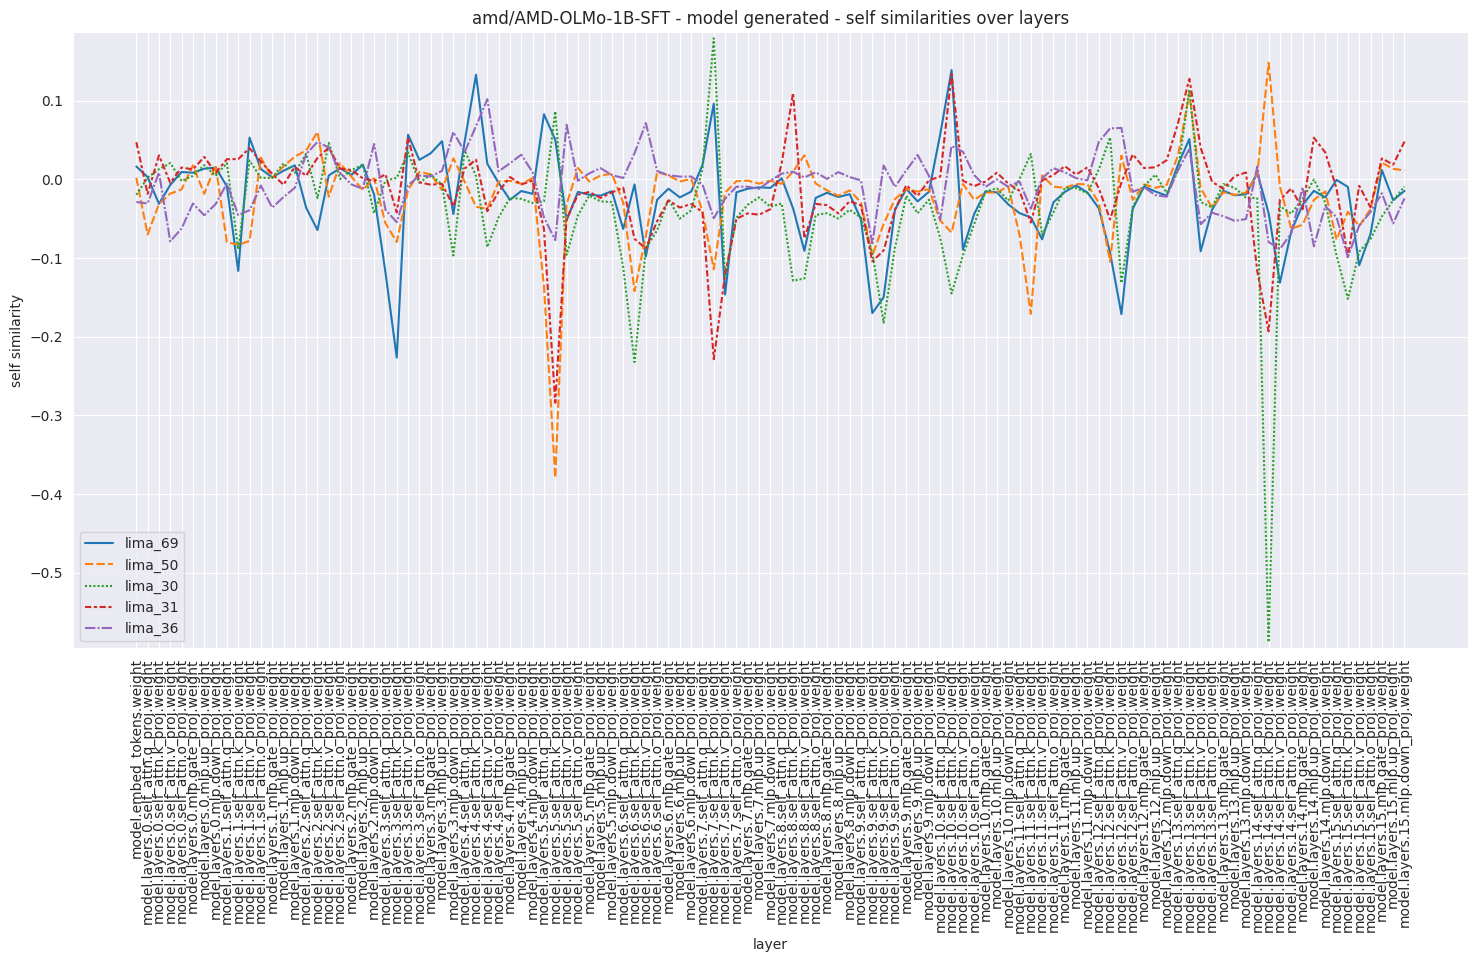

In [37]:
plot_gradient_similarities_over_layers(
    examples=examples_where_similarity_diverges_the_most_between_single_layer_gradient_and_full_gradient_model_generated,
    gradient_similarities_per_layer_old_structure=cosine_similarities_old_structure_model_generated,
    title=f"{model_to_evaluate} - model generated - self similarities over layers",
    storage_folder_path=get_results_self_similarities_over_layers_folder_path(model_to_evaluate, sample_size, ExperimentType.MODEL_GENERATED),
)

## 2.2 Comparison between Layer-Gradient-Similarities and Full-Gradient-Similarities

In [38]:
layer_similarity_compared_to_full_gradients_model_generated = calculate_similarity_between_single_layer_gradient_similarity_and_full_gradient_similarity(cosine_similarities_new_structure_model_generated, cosine_similarities_old_structure_combined_model_generated)

In [39]:
max(layer_similarity_compared_to_full_gradients_model_generated, key=layer_similarity_compared_to_full_gradients_model_generated.get)

'model.layers.3.mlp.down_proj.weight'

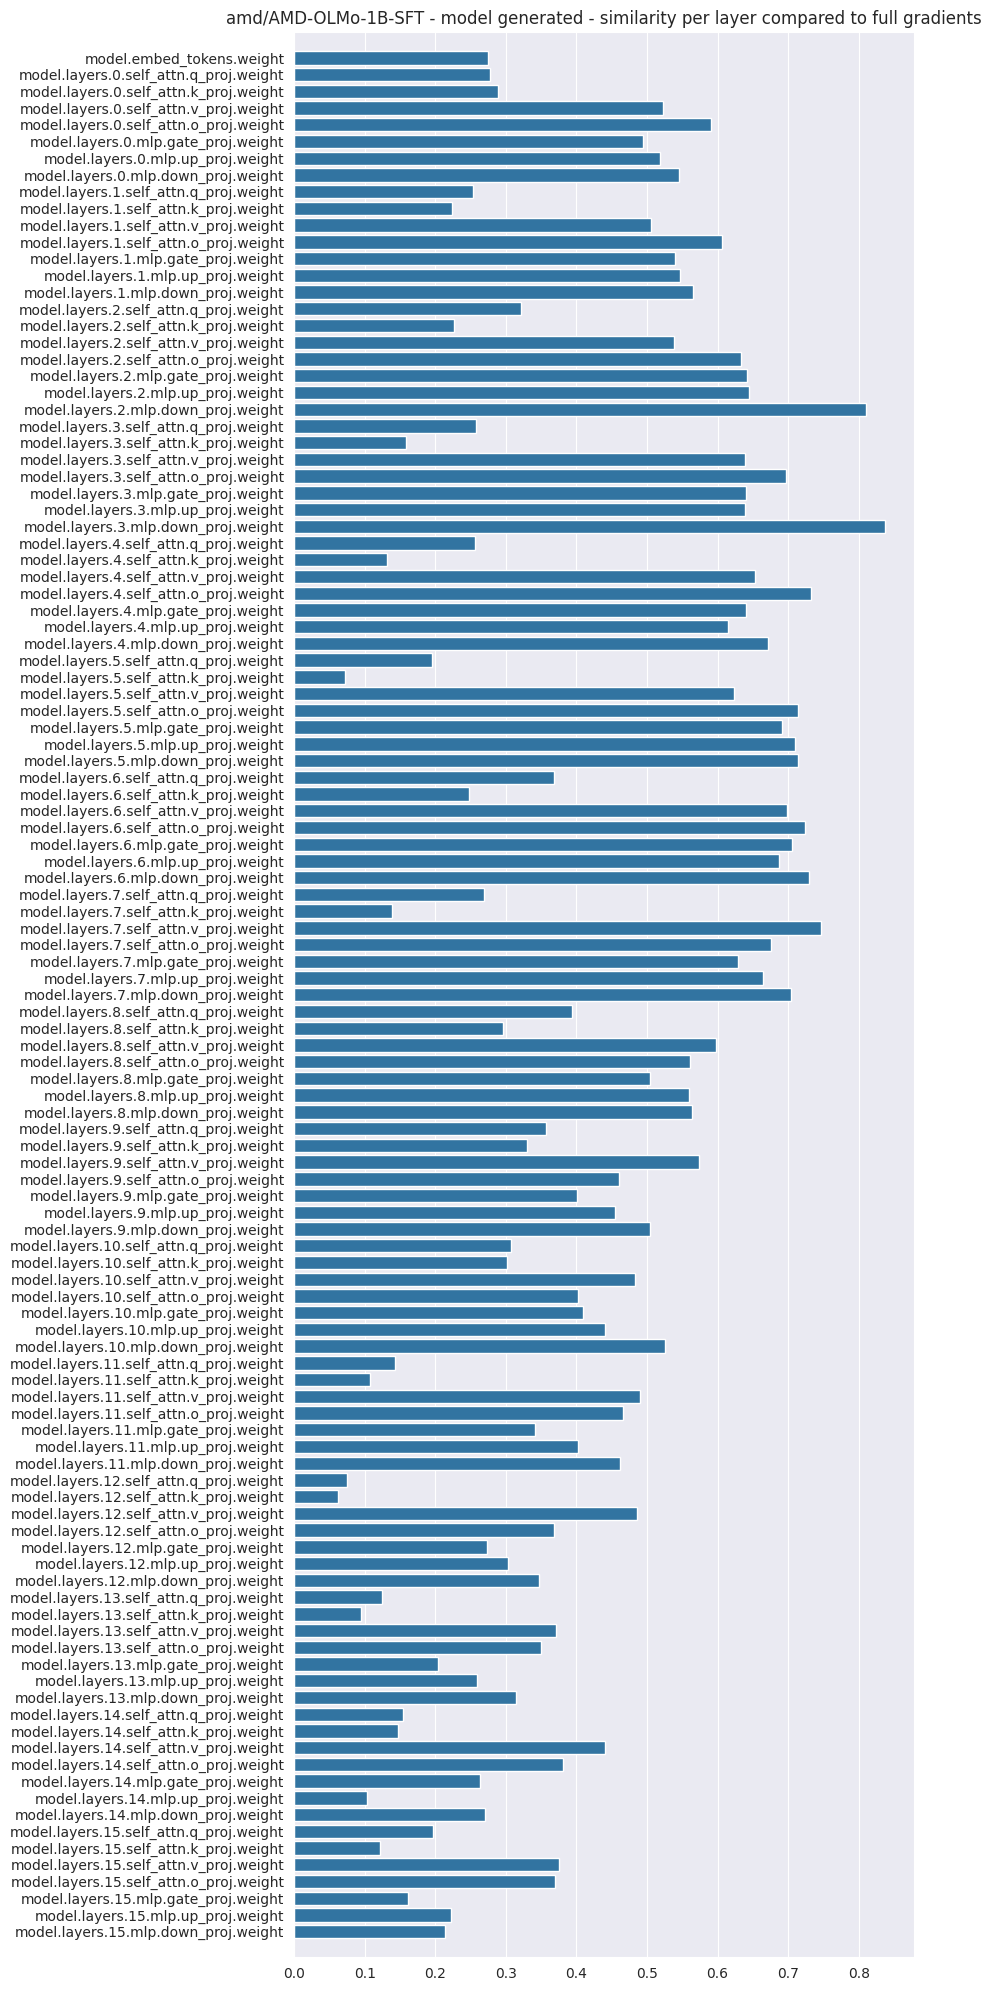

In [40]:
horizontal_bar_plot(
    y=list(layer_similarity_compared_to_full_gradients_model_generated.keys()),
    x=list(layer_similarity_compared_to_full_gradients_model_generated.values()),
    title=f"{model_to_evaluate} - model generated - similarity per layer compared to full gradients",
    storage_folder_path=get_results_layer_comparison_full_gradient_folder_path(model_to_evaluate, sample_size, ExperimentType.MODEL_GENERATED),
)

with open(f"{get_results_layer_comparison_full_gradient_folder_path(model_to_evaluate, sample_size, ExperimentType.MODEL_GENERATED)}/values.json", "w") as f:
    json.dump(layer_similarity_compared_to_full_gradients_model_generated, f, indent=4)

### 2.2.1 Greedy Layer Selection based on Full-Gradient-Comparison

In [41]:
greedily_selected_layers_model_generated = greedy_forward_layer_selection(layer_dot_products_model_generated, cosine_similarities_old_structure_combined_model_generated)

In [42]:
# accumulate layer parameters for visualization

parameter_percentage_accumulated_and_similarity_model_generated = []
accumulated_parameters = 0

for layer, similarity_compared_to_full_gradient in greedily_selected_layers_model_generated:
    accumulated_parameters += num_parameters_per_layer[layer]

    parameter_percentage_accumulated_and_similarity_model_generated.append((accumulated_parameters / model.num_parameters() * 100, similarity_compared_to_full_gradient))

In [43]:
pd.DataFrame(data=parameter_percentage_accumulated_and_similarity_model_generated, columns=["percentage", 'similarity'])

percentage  similarity
0      1.425707    0.836780
1      1.782134    0.879166
2      3.207841    0.901684
3      4.633549    0.919451
4      6.059256    0.932914
..          ...         ...
108   95.366451    0.999972
109   96.792159    0.999983
110   97.148585    0.999988
111   98.574293    0.999997
112  100.000000    1.000000

[113 rows x 2 columns]

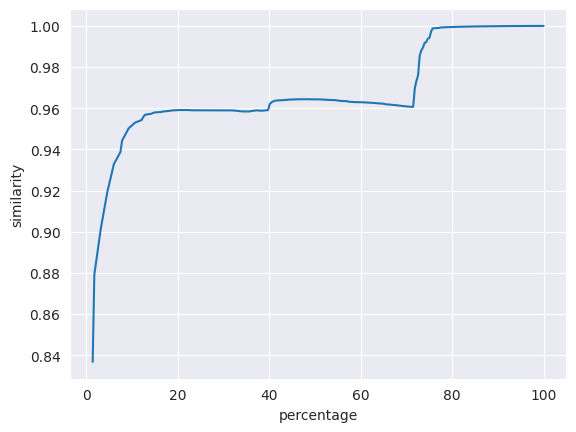

In [44]:
sns.lineplot(data=pd.DataFrame(data=parameter_percentage_accumulated_and_similarity_model_generated, columns=["percentage", 'similarity']), x="percentage", y="similarity")
plt.show()

# 3. Accuracy Comparison

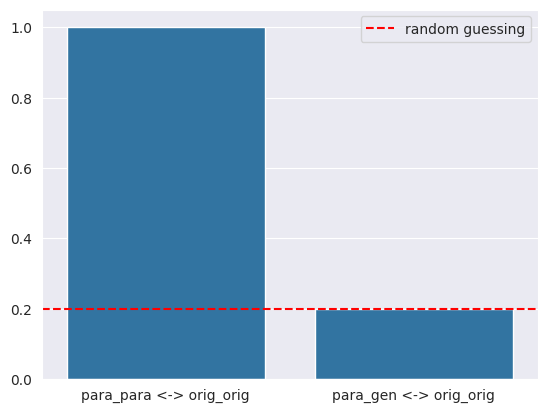

In [45]:
# create bar plot with paraphrased_score, paraphrased_model_generated_score, and horizontal line at 0.2 baseline
sns.barplot(x=["para_para <-> orig_orig", "para_gen <-> orig_orig"], y=[model_score, model_score_model_generated])

plt.axhline(y=0.2, color='r', linestyle='--', label="random guessing")
plt.legend()
plt.show()